In [43]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

<h2><center>Purpose</center></h2>Purpose
The following code assembles a series of lagrangians which can be used to set up two coupled differential equations. These equations are then solved to give an animation in matplotlib. The data from that point is exported as a csv file to be animated in a 3d rendering software. Simply the point of this script is animating a closed orbit around the Yukawa potential and then exporting it to blender 3d rendering software.


In [44]:
#defining variables for sympy to recognize 
t, a, m = smp.symbols('t a m')

v_zero = smp.symbols(r'V_0')


r = smp.symbols('r' ,cls =smp.Function)
theta = smp.symbols(r'\theta',cls=smp.Function)

<h2><center>Setting up our equations</center></h2>



<center>We want to solve for orbit around the potential </center>

$$
   V = \frac{-V_0e^{-ar}}{r}
$$ 




In [45]:
#establishing r and theta are functions of t
r = r(t)
theta = theta(t)

#establishing differentials of theta and d
theta_d = smp.diff(theta,t)
r_d = smp.diff(r,t)

theta_dd = smp.diff(theta_d,t)
r_dd = smp.diff(r_d,t)

<h2><center>Setting up the lagrangian</center></h2>



<center>We want to set up the lagrangians for the object </center>

$$
   V = -\frac{V_0e^{-ar}}{r}
$$ 

$$
   T = \frac{1}{2}m\left(\left(\frac{dr}{dt}\right)^2+\left(\frac{d\theta}{dt}\right)^2\right)
$$ 

$$
    \mathcal{L} = T-V
$$



In [46]:
#here we're setting up the lagrangian in sympy
T = 1/2*m*(r_d**2+r**2*theta_d**2)
V = -v_zero/r*smp.E**(-a*r)
L = T-V

<h2><center>Lagrangian Equations of Motion</center></h2>
$$
   \frac{d}{dt}\frac{\partial \mathcal{L}}{\partial \dot{r}} = \frac{\partial \mathcal{L}}{\partial r}
$$ 

$$
   \frac{d}{dt}\frac{\partial \mathcal{L}}{\partial \dot{\theta}} = \frac{\partial \mathcal{L}}{\partial \theta}
$$ 

In [47]:
#LEM1 and LEM2 are the equations of motion
LEM1 = smp.diff(L,theta)-smp.diff(smp.diff(L,theta_d),t).simplify()

LEM2 = smp.diff(L,r)-smp.diff(smp.diff(L,r_d),t).simplify()

In [48]:
#here we solve the equations of motion for the double derivative of theta and r
solve = smp.solve([LEM1, LEM2], (theta_dd, r_dd), simplify=False, rational=False)

#next we lambdify the functions to prepare them for numerical calculation
dz1dt_f = smp.lambdify((t,m,v_zero,theta,theta_d,r,r_d), solve[theta_dd])
dthetadt_f = smp.lambdify(theta_d,theta_d)
dz2dt_f = smp.lambdify((t,a,m,v_zero,theta,theta_d,r,r_d), solve[r_dd])
drdt_f = smp.lambdify(r_d,r_d)


In [49]:
#Setting up he function definition for the ODE solver with our lambdified function
def dSdt(S,t,a,m,v_zero):
    #these are the initial conditions z1 and z2 are the angular and radial velocities respectively
    theta, z1, R, z2 = S
    return[
    dthetadt_f(z1),
    dz1dt_f(t,m,v_zero, theta, z1, R, z2),
    dthetadt_f(z2),
    dz2dt_f(t,a,m,v_zero, theta, z1, R, z2),
    ]

In [50]:
#t will be solved from 0 to 40s on an interval of 1000
t = np.linspace(0,40,1000)
#random values given to a, m, and V_0
a = 2
m = 3
v_zero = 50

#ans is a multidimentional numpy array that contains all our values for theta, r, and t

#y0= [0,2,1,0] correspond to the initial conditions [theta_0, initial angular velocity, R_0, and initial radial velocity]
ans = odeint(dSdt, y0=[0,2,1,0], t=t, args=(a,m,v_zero))

<h2><center>Below are the graphs of R and theta, notice the cyclical nature</center></h2>

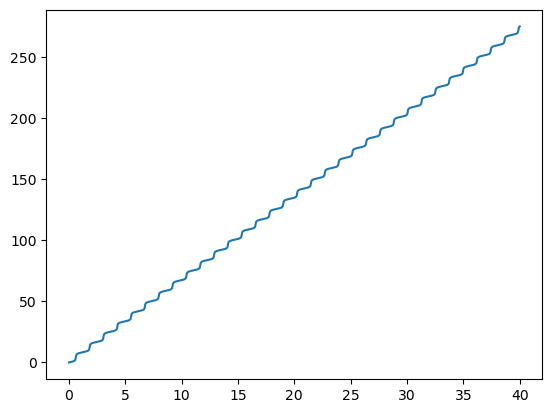

In [51]:
#setting theta to be equal to the fiest element of the array, (we know this from S in dSdt)
theta = ans.T[0]
plt.plot(t,theta)

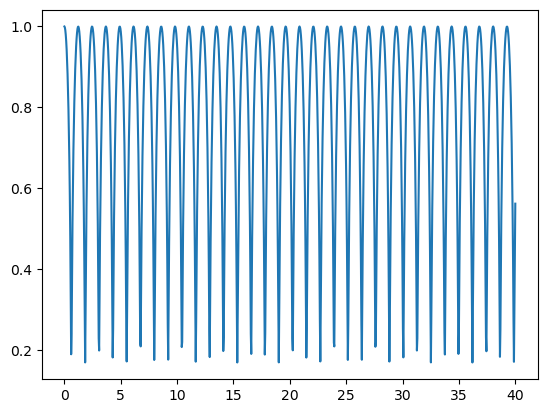

In [34]:
#setting theta to be equal to the fiest element of the array, (we know this from S in dSdt)
r = ans.T[2]
plt.plot(t,r)

In [36]:
#setting up a simple function that gives us a numpy array for x and y instead of R and theta
def get_xy(t,theta,r):
    return(r*np.sin(theta),r*np.cos(theta))

x,y = get_xy(t, ans.T[0], ans.T[2])

<h2><center>Animating the data</center></h2>
<center>Now that we have our data we can animate it in matplotlib, and we can export it to a CSV file to be used in blender</center>


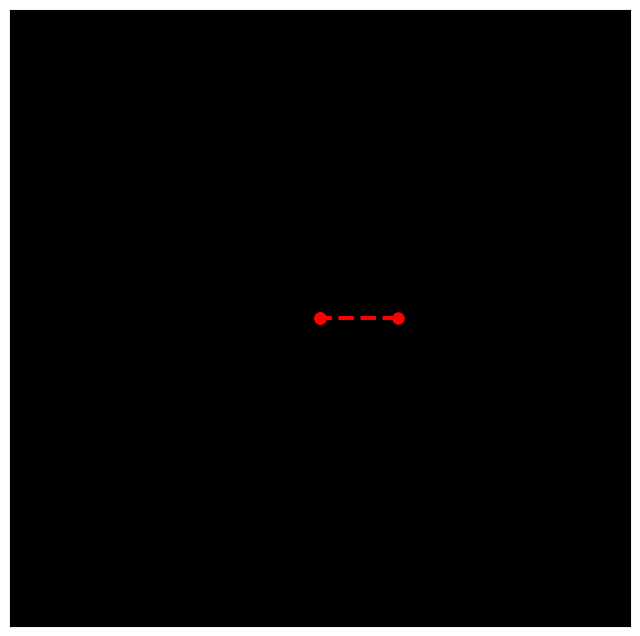

In [37]:
#animation script not too important, mostly to demonstrate, we solved the equations correctly

#animation function, will be used as a parameter by .FuncAnimation 
def animate(i):
    #essentially gives us x and y of t where i = t
    ln1.set_data([y[i],0,0],[x[i],0,0])

    
#style choices
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ln1, = plt.plot([],[],'ro--', lw=3,markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)

#passes a parameter t through the animate funtion to get the data to be ploted on each fram, uses fig as a parameter as
#to what we are plotting to:
ani = animation.FuncAnimation(fig,animate,frames=1000,interval=25)
ani.save('Yukawa.gif', writer = 'pillow', fps=25)

In [38]:
#the following code export the simulation data as a CSV file for importing to other more sophisticated visualization software
import csv
new_list = [['time','x','y']]
csv_path = 'Yukawa_potential_data.csv'
for i in range(1000):
    new_list.append([t[i],x[i],y[i]])
with open(csv_path, mode='w', newline='') as file:
    # Create a csv.writer object
    writer = csv.writer(file)
    # Write data to the CSV file
    writer.writerows(new_list)
